In [1]:
# Execute this cell first to load custom css
from IPython.core.display import HTML
HTML(filename="./assets/theme.html")

![MLU_Logo](./assets/MLU_Logo.png)

# Quick Start Workshop to Modern Forecasting

## <a name="0">NOTEBOOK 2. DeepAR Forecasting Algorithm in GluonTS</a>


### Forecasting with DeepAR in GluonTS

DeepAR is a supervised learning algorithm for forecasting scalar time series using recurrent neural networks (RNNs).

A main charactersistic of DeepAR is that it can work on multivariate and multiple time series. It is in that regime where DeepAR outperforms classical forecasting methods. The training input for the DeepAR algorithm is one or, preferably, multiple target time series that have been generated by the same process or similar processes. Based on this input dataset, the algorithm trains a model that learns an approximation of this process/processes and uses it to predict how the target time series evolves.

GluonTS’s pre-built DeepAR estimator (`DeepAREstimator`) implements an RNN-based model, close to the one described in [Salinas et al. "DeepAR: Probabilistic forecasting with autoregressive recurrent networks."](https://arxiv.org/abs/1704.04110)

Some of the available parameters of the DeepAR estimator are: 

 * `freq` – Frequency of the data to train on and predict
 * `prediction_length` – Length of the prediction horizon
 * `trainer` – Trainer object to be used (default: `Trainer()`)
 * `context_length` – Number of steps to unroll the RNN for before computing predictions (default: `None`, in which case `context_length = prediction_length`)
 * `num_layers` – Number of RNN layers (default: 2)
 * `num_cells` – Number of RNN cells for each layer (default: 40)
 * `cell_type` – Type of recurrent cells to use (available: `‘lstm’` or `‘gru’`; default: `‘lstm’`)

### Table of Contents

1. <a href="#1">GluonTS's DeepAR Estimator</a> 
2. <a href="#2">Evaluating Forecasts</a> 
3. <a href="#3">Improving Your DeepAR Model</a>

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install --upgrade --quiet gluonts

# Import libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import gluonts
import mxnet as mx
from mxnet import gluon

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

gluonts.__version__

'0.10.7'

In [4]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.mx import Trainer

## <a name="1">1. GluonTS's DeepAR Estimator</a>

(<a href="#0">Go to top</a>)


As mentioned above, DeepAR, as well as other neural-based forecasting architectures, works really well with multivariate data. A global model is built by using **multiple time series** which are slightly different among them but are otherwise the product of the same generating process. 

This property finds application in many real world scenarios. In the Amazon case, we might want to forecast sales for each one of the millions of products in the Amazon catalog. It is almost certain that each product will sell with a different pattern, but we can still use information from existing similar products to predict sales for a new one. This solves the so-called cold-start problem in a manner that classical, local-model forecasting approaches can not.

For this example we will use the data set [M4-hourly](https://en.wikipedia.org/wiki/Makridakis_Competitions#Fourth_competition,_started_on_January_1,_2018,_ended_on_May_31,_2018), a subset of the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) data set that consists of a collection of 414 time series sampled at 1h intervals. 


In [5]:
dataset = get_dataset("m4_hourly", regenerate=False)

GluonTS’s built-in DeepAR recurrent neural network (`DeepAREstimator`) accepts an input window of length `context_length` and predicts the distribution of the values of the subsequent `prediction_length` values. In GluonTS parlance, the DeepAR recurrent neural network model is an example of `Estimator`. In GluonTS, `Estimator` objects represent a forecasting model as well as details such as its coefficients, weights, etc.

In general, each estimator (pre-built or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g., the `prediction_length`) or specific for the particular estimator (e.g., number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained i.e., the number of epochs, the learning rate, etc.

To train a DeepAR model, we initialize an `Estimator` object with appropriate arguments, and we call the method `train` on the training data set to create the `predictor`. 

Notice that in the initialization below we are using all the default parameters from the GluonTS's `Trainer` except for the number of `epochs`. For this first example let us train for only 5 epochs to get a quick first result.

In [6]:
# Run this cell to see the values of the default parameters of the GluonTS's Trainer
Trainer?

In [7]:
# Initialization of the DeepAR estimator
estimator = DeepAREstimator(
    prediction_length=dataset.metadata.prediction_length,
    freq=dataset.metadata.freq,
    trainer=Trainer(
        epochs=5
    ),
)

In [8]:
# Training on the training data set
predictor = estimator.train(dataset.train)

  0%|          | 0/50 [00:00<?, ?it/s]

[2022-10-05 18:16:52.110 ip-172-16-88-66:32155 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-10-05 18:16:52.158 ip-172-16-88-66:32155 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


100%|██████████| 50/50 [00:04<00:00, 11.24it/s, epoch=5/5, avg_epoch_loss=4.52]


Once the estimator has been trained, we can use the `predict` method on the train prediction to produce forecasts. GluonTS incorporates a handy [`make_evaluation_predictions`](https://github.com/awslabs/gluon-ts/blob/master/src/gluonts/evaluation/backtest.py#L35) method that returns a tuple of iterators. The first one yields the forecasts and the second one yields the corresponding ground truth time series.

The parameter `num_samples` contains the number of samples to draw on the model when evaluating. Only sampling-based models, such as DeepAR, will use this.

In [9]:
forecast_iter, timeseries_iter = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,   # predictor
    num_samples=100,       # number of sample paths we want for evaluation
)

In [10]:
# Convert the generators to lists
forecasts = list(forecast_iter)
timeseries = list(timeseries_iter)

After converting the forecasting generators to list for easy inspection, let us look at the first of the forecast time series. 

In [11]:
# First entry of the forecast list
first_forecast = forecasts[0]
first_timeseries = timeseries[0]

Each of the forecasts is an object of the class [`SampleForecast`](https://github.com/awslabs/gluon-ts/blob/master/src/gluonts/model/forecast.py#L306), where the predicting probabilistic distribution is represented internally as samples. 

A `SampleForecast` object contains the following elements:
 * `samples`: array of containing all samples draws from the probabilistic forecast model
 * `start_date`: start of the forecast
 * `freq`: frequency of the forecast time series
 * `info`: additional information that the forecaster may provide e.g. estimated parameters, number of iterations ran etc.

<a id='ex'></a>
### <mark>Exercise: Inspect the forecast obtained for the first time series.

- How many samples have been drawn?
- What is the shape of the samples?
- What is the start date of the forecast window?
- What is the frequency of the time series?

The information is contained in the elements of the `SampleForecast` object.
    
You can code your answer in the cell below. If you get stuck or want to check out your results, please uncomment the `load` line.

In [12]:
# %load answers/sample_forecast.py


GluonTS `SampleForecast` objects have a plot method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

The function below plots the train+test data together with the forecast, including the 80% and 95% prediction intervals.

In [13]:
# Custom plot routine to visualize the results of the DeepAR forecast

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_prob_forecasts(ts_entry, forecast_entry):
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    plot_length = 150
    end_train = len(ts_entry)-dataset.metadata.prediction_length

    ts_entry[-plot_length : end_train].plot(ax=ax, label="train")
    ts_entry[end_train : ].plot(ax=ax, label="test")

    forecast_entry.plot(prediction_intervals=(80.0, 95.0), color='b', show_mean=False)

    # Produce timeseries containing the median of the probabilistic forecast to plot it
    forecast_entry_median = pd.Series(forecast_entry.quantile(0.5), index=ts_entry[end_train : ].index)
    forecast_entry_median.plot(ax=ax, c="y", lw=3)
    
    # Custom legend elements
    legend_elements = [Line2D([0], [0], color='b', label='train'),
                       Line2D([0], [0], color='orange', label='test'),
                       Line2D([0], [0], color='y', lw=3, label='DeepAR forecast (median)'),
                       Patch(facecolor='b', alpha=0.6, label='p80'),
                       Patch(facecolor='b', alpha=0.3, label='p95')]
    plt.grid(which="both")
    plt.legend(handles=legend_elements, loc="upper left")
    plt.show()

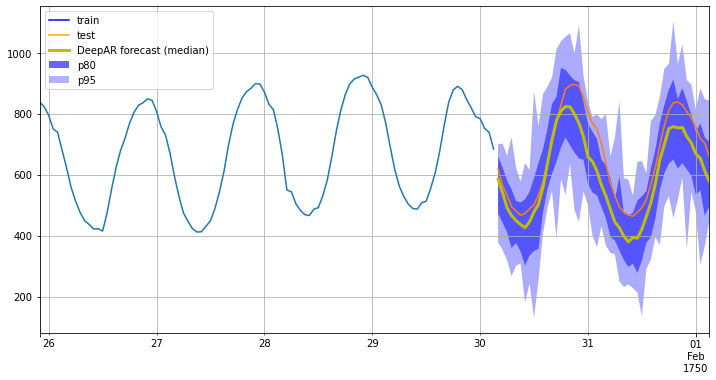

In [14]:
plot_prob_forecasts(first_timeseries, first_forecast)

<a id='ex'></a>
### <mark>Exercise: Visualize the forecast for other time series in the data set.

- Plot the train, test, and forecast data of the last time series in the data set
    
You can code your answer in the cell below. If you get stuck or want to check out your results, please uncomment the `load` line.

In [15]:
# %load answers/visualize.py


## <a name="2">2. Evaluating Forecasts</a>

(<a href="#0">Go to top</a>)

We can also evaluate the quality of our forecasts using various evaluation metrics. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

Below we compute metrics for the quantile 0.5, equivalent to a point forecast for the median of the forecast distribution.

In [16]:
from gluonts.evaluation import Evaluator

In [17]:
evaluator = Evaluator(quantiles=[0.5])
agg_metrics, item_metrics = evaluator(iter(timeseries), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 3582.29it/s]


Individual metrics are aggregated across time steps for the prediction interval.

In [18]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.5],Coverage[0.5]
0,0,5727.394531,3201.477051,31644.0,659.250000,42.371302,1.574118,0.101949,0.108938,0.101172,10.263194,3201.477020,0.041667
1,1,32251.317708,6824.360352,124149.0,2586.437500,165.107988,0.861098,0.053177,0.053144,0.054969,10.606641,6824.359985,0.666667
2,2,122839.791667,14400.853516,65030.0,1354.791667,78.889053,3.803034,0.206825,0.235986,0.221449,27.830149,14400.852844,0.000000
3,3,609152.000000,29935.525391,235783.0,4912.145833,258.982249,2.408106,0.119914,0.131441,0.126962,12.177259,29935.525879,0.062500
4,4,339999.333333,24031.601562,131088.0,2731.000000,200.494083,2.497123,0.173318,0.192693,0.183324,17.938453,24031.601685,0.000000


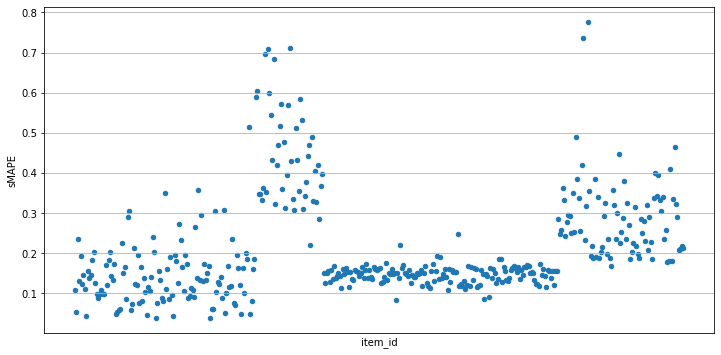

In [19]:
item_metrics.plot(x='item_id', y='sMAPE', kind='scatter', figsize=(12,6))
plt.grid(which="both")
plt.xticks([])
plt.show()

<a id='ex'></a>
### <mark>Exercise: Best and worst forecasts.

- Among the 141 time series in the data set, identify the ones with the best and worse forecast in terms of symmetric mean absolute percentage error
- Plot the best and worse forecast alongside the train and test data

You can code your answer in the cell below. If you get stuck or want to check out your results, please uncomment the `load` line.

In [20]:
# %load answers/best_worst.py


Aggregate metrics aggregate both across time-steps and across time series.

In [21]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 16201884.271064483,
    "abs_error": 12535779.873661041,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 9.336503148154437,
    "MAPE": 0.20635140400481883,
    "sMAPE": 0.20847814017231905,
    "MSIS": 58.10419824427441,
    "QuantileLoss[0.5]": 12535779.777054787,
    "Coverage[0.5]": 0.15574677938808373,
    "RMSE": 4025.156428148412,
    "NRMSE": 0.5495227604976979,
    "ND": 0.08612172123123585,
    "wQuantileLoss[0.5]": 0.08612172056754384,
    "mean_absolute_QuantileLoss": 12535779.777054787,
    "mean_wQuantileLoss": 0.08612172056754384,
    "MAE_Coverage": 0.34425322061191627,
    "OWA": NaN
}


## <a name="3">3. Improving Your DeepAR Model</a>

(<a href="#0">Go to top</a>)

The model above has been trained for only 5 epochs (one epoch is a full pass over all the training data points) and otherwise using default hyperparameters of the `DeepAR` algorithm and the GluonTS's `Trainer`. 

Possibly a more performant model can be built by tuning the available hyperparameter values.


In [22]:
# Run this cell to see the values of the default parameters of the GluonTS's Trainer
DeepAREstimator?

In [23]:
# Run this cell to see the values of the default parameters of the GluonTS's Trainer
Trainer?

<a id='ex'></a>
### <mark>Exercise: Improve your DeepAR forecast.

- Explore the hyperparameters of the DeepAR algorithm, train a new model using them and compute evaluation metrics. Then check whether your forecast improves with respect to the model built in Section 1.  

You can code your answer in the cell below. If you get stuck or want to check out your results, please uncomment the `load` line.

In [24]:
# %load answers/improved.py
# Initialization of the DeepAR estimator


## **Conclusion**

In this notebook we've seen how to leverage the GluonTS library to produce forecasts using an implementation of the DeepAR estimator based on recurrent LSTM cells. We have learned how to visualize the predicted values for the time series as well as to how to compute evaluation metrics. We have experimented with hyperparameters to improve the results. 

Other forecasting models implemented in the GluonTS library can be found in the [`gluonts.model`](https://ts.gluon.ai/api/gluonts/gluonts.model.html) module. 